## Cargar los datos 
### DataFrame:


In [4]:
# Importamos las librerías necesarias.
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Cargamos los datos.
valoraciones = pd.read_json('data/web_reviews.json')

# Función .info()
## El resultado de `valoraciones.info()` es que contiene un total de **10,261 filas** y **9 columnas**.
**Columnas:**
- **reviewerID**: ID del revisor, tipo `object` (cadena de texto).
- **asin**: ID del producto, tipo `object`.
- **reviewerName**: Nombre del revisor, tipo `object`.
- **helpful**: Información sobre la utilidad de la reseña (como una lista que muestra votos útiles), tipo `object`.
- **reviewText**: Texto de la reseña, tipo `object`.
- **overall**: Calificación general del producto (1 a 5), tipo `int64`.
- **summary**: Resumen breve de la reseña, tipo `object`.
- **unixReviewTime**: Fecha de la reseña en formato de tiempo Unix, tipo `int64`.
- **reviewTime**: Fecha de la reseña en formato de texto, tipo `object`.

### Información adicional:
- **Tipos de datos**: La mayoría de las columnas son de tipo `object` (cadenas de texto), excepto `overall` y `unixReviewTime`, que son enteros (`int64`).
- **Uso de memoria**: El DataFrame ocupa aproximadamente **721.6 KB** en memoria.


In [5]:
valoraciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10261 non-null  object
 1   asin            10261 non-null  object
 2   reviewerName    10261 non-null  object
 3   helpful         10261 non-null  object
 4   reviewText      10261 non-null  object
 5   overall         10261 non-null  int64 
 6   summary         10261 non-null  object
 7   unixReviewTime  10261 non-null  int64 
 8   reviewTime      10261 non-null  object
dtypes: int64(2), object(7)
memory usage: 721.6+ KB


## .describe
El resultado de `valoraciones.describe()` proporciona un resumen estadístico de las columnas **numéricas** en el DataFrame. Ayudan a entender la distribución y la tendencia de las calificaciones junto con los tiempos de revisión:

### Interpretación:
- **overall**: 
  - Representa la calificación general del producto.
  - La media es de **4.59**, lo cual indica que la mayoría de las valoraciones son altas.
  - El valor mínimo es **1** y el máximo es **5**.
  
- **unixReviewTime**: 
  - Representa la fecha de la reseña en formato Unix.
  - La media es **1.356565e+09**, y el rango va desde **1.204819e+09** hasta **1.405382e+09**.

In [6]:
valoraciones.describe()

,overall,unixReviewTime
count,10261.000000,1.026100e+04
mean,4.488744,1.360606e+09
std,0.894642,3.779735e+07
min,1.000000,1.095466e+09
25%,4.000000,1.343434e+09
50%,5.000000,1.368490e+09
75%,5.000000,1.388966e+09
max,5.000000,1.405987e+09


## Entrenamos un modelo 


Importancia de las características:
             Feature  Importance
0     unixReviewTime    0.402677
1  reviewText_length    0.387597
2     summary_length    0.209725


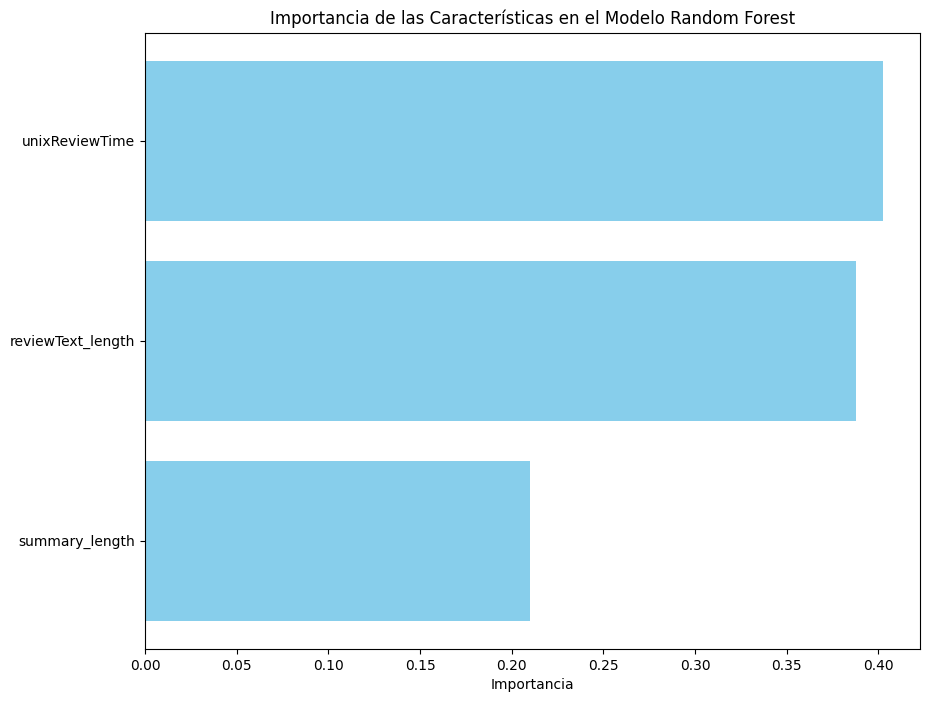


Precisión del modelo con características seleccionadas: 0.63
Precisión de Random Forest: 0.63
Precisión de Gradient Boosting: 0.67
Precisión de Decision Tree: 0.51
Precisión de Logistic Regression: 0.67


In [26]:
# Importamos las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score 

# Ajustamos la columna 'helpful' para obtener el número de votos útiles
valoraciones['helpful_votes'] = valoraciones['helpful'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 0)

# Convertimos todas las columnas de tipo object a valores numéricos
for column in valoraciones.select_dtypes(include=['object']).columns:
    if column == 'reviewText':
        # Nueva característica con la longitud del texto
        valoraciones['reviewText_length'] = valoraciones['reviewText'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    elif column == 'summary':
        # Nueva característica con la longitud del resumen
        valoraciones['summary_length'] = valoraciones['summary'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    else:
        # Eliminamos columnas irrelevantes
        valoraciones = valoraciones.drop(columns=[column])

# Seleccionamos todas las características menos la columna objetivo 'overall'
X = valoraciones[['unixReviewTime', 'reviewText_length', 'summary_length']]
y = valoraciones['overall']

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Entrenamos un modelo de Random Forest para calcular la importancia de las características
modelo_rf = RandomForestClassifier(random_state=1)
modelo_rf.fit(X_train, y_train)

# Obtenemos la importancia de las características
importancias = modelo_rf.feature_importances_
features = X.columns

# Creamos un DataFrame para visualizar la importancia de cada característica
importantesDf = pd.DataFrame({'Feature': features, 'Importance': importancias})
importantesDf = importantesDf.sort_values(by='Importance', ascending=False)

# Mostrar DataFrame de importancias
print("\nImportancia de las características:")
print(importantesDf)

# Visualizamos las importancias de características
plt.figure(figsize=(10, 8))
plt.barh(importantesDf['Feature'], importantesDf['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las Características en el Modelo Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Filtramos las características menos relevantes según un umbral de importancia
umbral_importancia = 0.01  # Ajusta este valor según los resultados
mejores_features = importantesDf[importantesDf['Importance'] > umbral_importancia]['Feature'].tolist()

# Creamos el conjunto de datos final solo con las características más relevantes
X_train_mejores = X_train[mejores_features]
X_test_mejores = X_test[mejores_features]

# Entrenamos y evaluamos el modelo con las características seleccionadas
modelo_final = RandomForestClassifier(random_state=1)
modelo_final.fit(X_train_mejores, y_train)
predicciones_final = modelo_final.predict(X_test_mejores)
accuracy_final = modelo_final.score(X_test_mejores, y_test)
print(f'\nPrecisión del modelo con características seleccionadas: {accuracy_final:.2f}')




# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Definimos los modelos a comparar
modelos = {
    'Random Forest': RandomForestClassifier(random_state=1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=1),
    'Decision Tree': DecisionTreeClassifier(random_state=1),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=1)
}

# Evaluamos cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X_test)
    accuracy = accuracy_score(y_test, predicciones)
    print(f'Precisión de {nombre}: {accuracy:.2f}')


## Buscar missing values

In [27]:
# Contamos los valores faltantes en cada columna
missing_values = valoraciones.isnull().sum()

# Filtramos solo las columnas que tienen valores faltantes
missing_values = missing_values[missing_values > 0]

# Mostramos los resultados
print("Valores faltantes por columna:")
print(missing_values)


Valores faltantes por columna:
Series([], dtype: int64)


## Eliminar missing values

## Imputación

## Imputación con media

## Imputación con moda

## Imputación con mediana

## Imputación con extension